# Using the picasso trained predictors

This notebook shows how one can use the trained models to make predictions of gas thermodynamics from halo properties.
For a full documentation of the predictor objects and their methods, see {doc}`../api/predictors`.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from picasso import predictors
from picasso.test_data import halos, profs

import seaborn as sns
sns.set_style("darkgrid")
sns.set_theme("notebook")

benchmark = True

We will use the `minimal_576` trained model, which takes as input halo mass and concentration:

In [2]:
predictor = predictors.minimal_576
print(predictor.input_names)

['log M200', 'c200']


## Predicting gas model parameters

First, we want to compute predictions for the model parameter vector, $\vartheta_{\rm gas}$.
To do so, we simply need the vector of scalar halo properties $\vartheta_{\rm halo}$.
We'll use some pre-stored data (containing four halos from the simulations presented in Kéruzoré+24) and write the input vector:

In [3]:
logM200c = halos["log M200"]
c200c = jnp.array(halos["c200"])
theta_halo = jnp.array([logM200c, c200c]).T
print(theta_halo.shape)

(7, 2)


We can then use the `predictor.predict_model_parameters()` function to predict $\vartheta_{\rm gas}$. For a single halo:

In [4]:
theta_gas_0 = predictor.predict_model_parameters(theta_halo[0])
print(theta_gas_0)

[6.8167767e+02 4.2554451e+01 1.1552830e+00 0.0000000e+00 9.0783482e-07
 4.2568062e-02 2.6434088e-01 8.6512649e-01]


The `predictor.predict_model_parameters()` function can also be used for several halos at a time:

In [5]:
theta_gas = predictor.predict_model_parameters(theta_halo)
print(f"{theta_gas=}")
print(f"{theta_gas.shape=}")

theta_gas=Array([[6.81677673e+02, 4.25544624e+01, 1.15528297e+00, 0.00000000e+00,
        9.07834817e-07, 4.25680615e-02, 2.64340878e-01, 8.65126491e-01],
       [1.15930457e+03, 6.67199860e+01, 1.14345777e+00, 0.00000000e+00,
        5.10627331e-07, 3.79818194e-02, 2.71961391e-01, 1.08983898e+00],
       [1.18055396e+03, 6.66861877e+01, 1.13935757e+00, 0.00000000e+00,
        3.46395638e-07, 4.17901538e-02, 3.04681391e-01, 1.08485985e+00],
       [6.25622437e+02, 3.45149117e+01, 1.14486837e+00, 0.00000000e+00,
        2.82427465e-07, 4.93658483e-02, 3.37841868e-01, 8.45696211e-01],
       [8.47131531e+02, 4.71525230e+01, 1.14094687e+00, 0.00000000e+00,
        1.76683585e-07, 4.33129147e-02, 3.45029294e-01, 9.40950334e-01],
       [9.07348572e+02, 5.16159096e+01, 1.14225698e+00, 0.00000000e+00,
        1.27210242e-07, 4.00005803e-02, 3.51588905e-01, 9.78283405e-01],
       [1.83323206e+03, 1.08152756e+02, 1.14192438e+00, 0.00000000e+00,
        7.68364785e-08, 2.49862876e-02, 3.247409

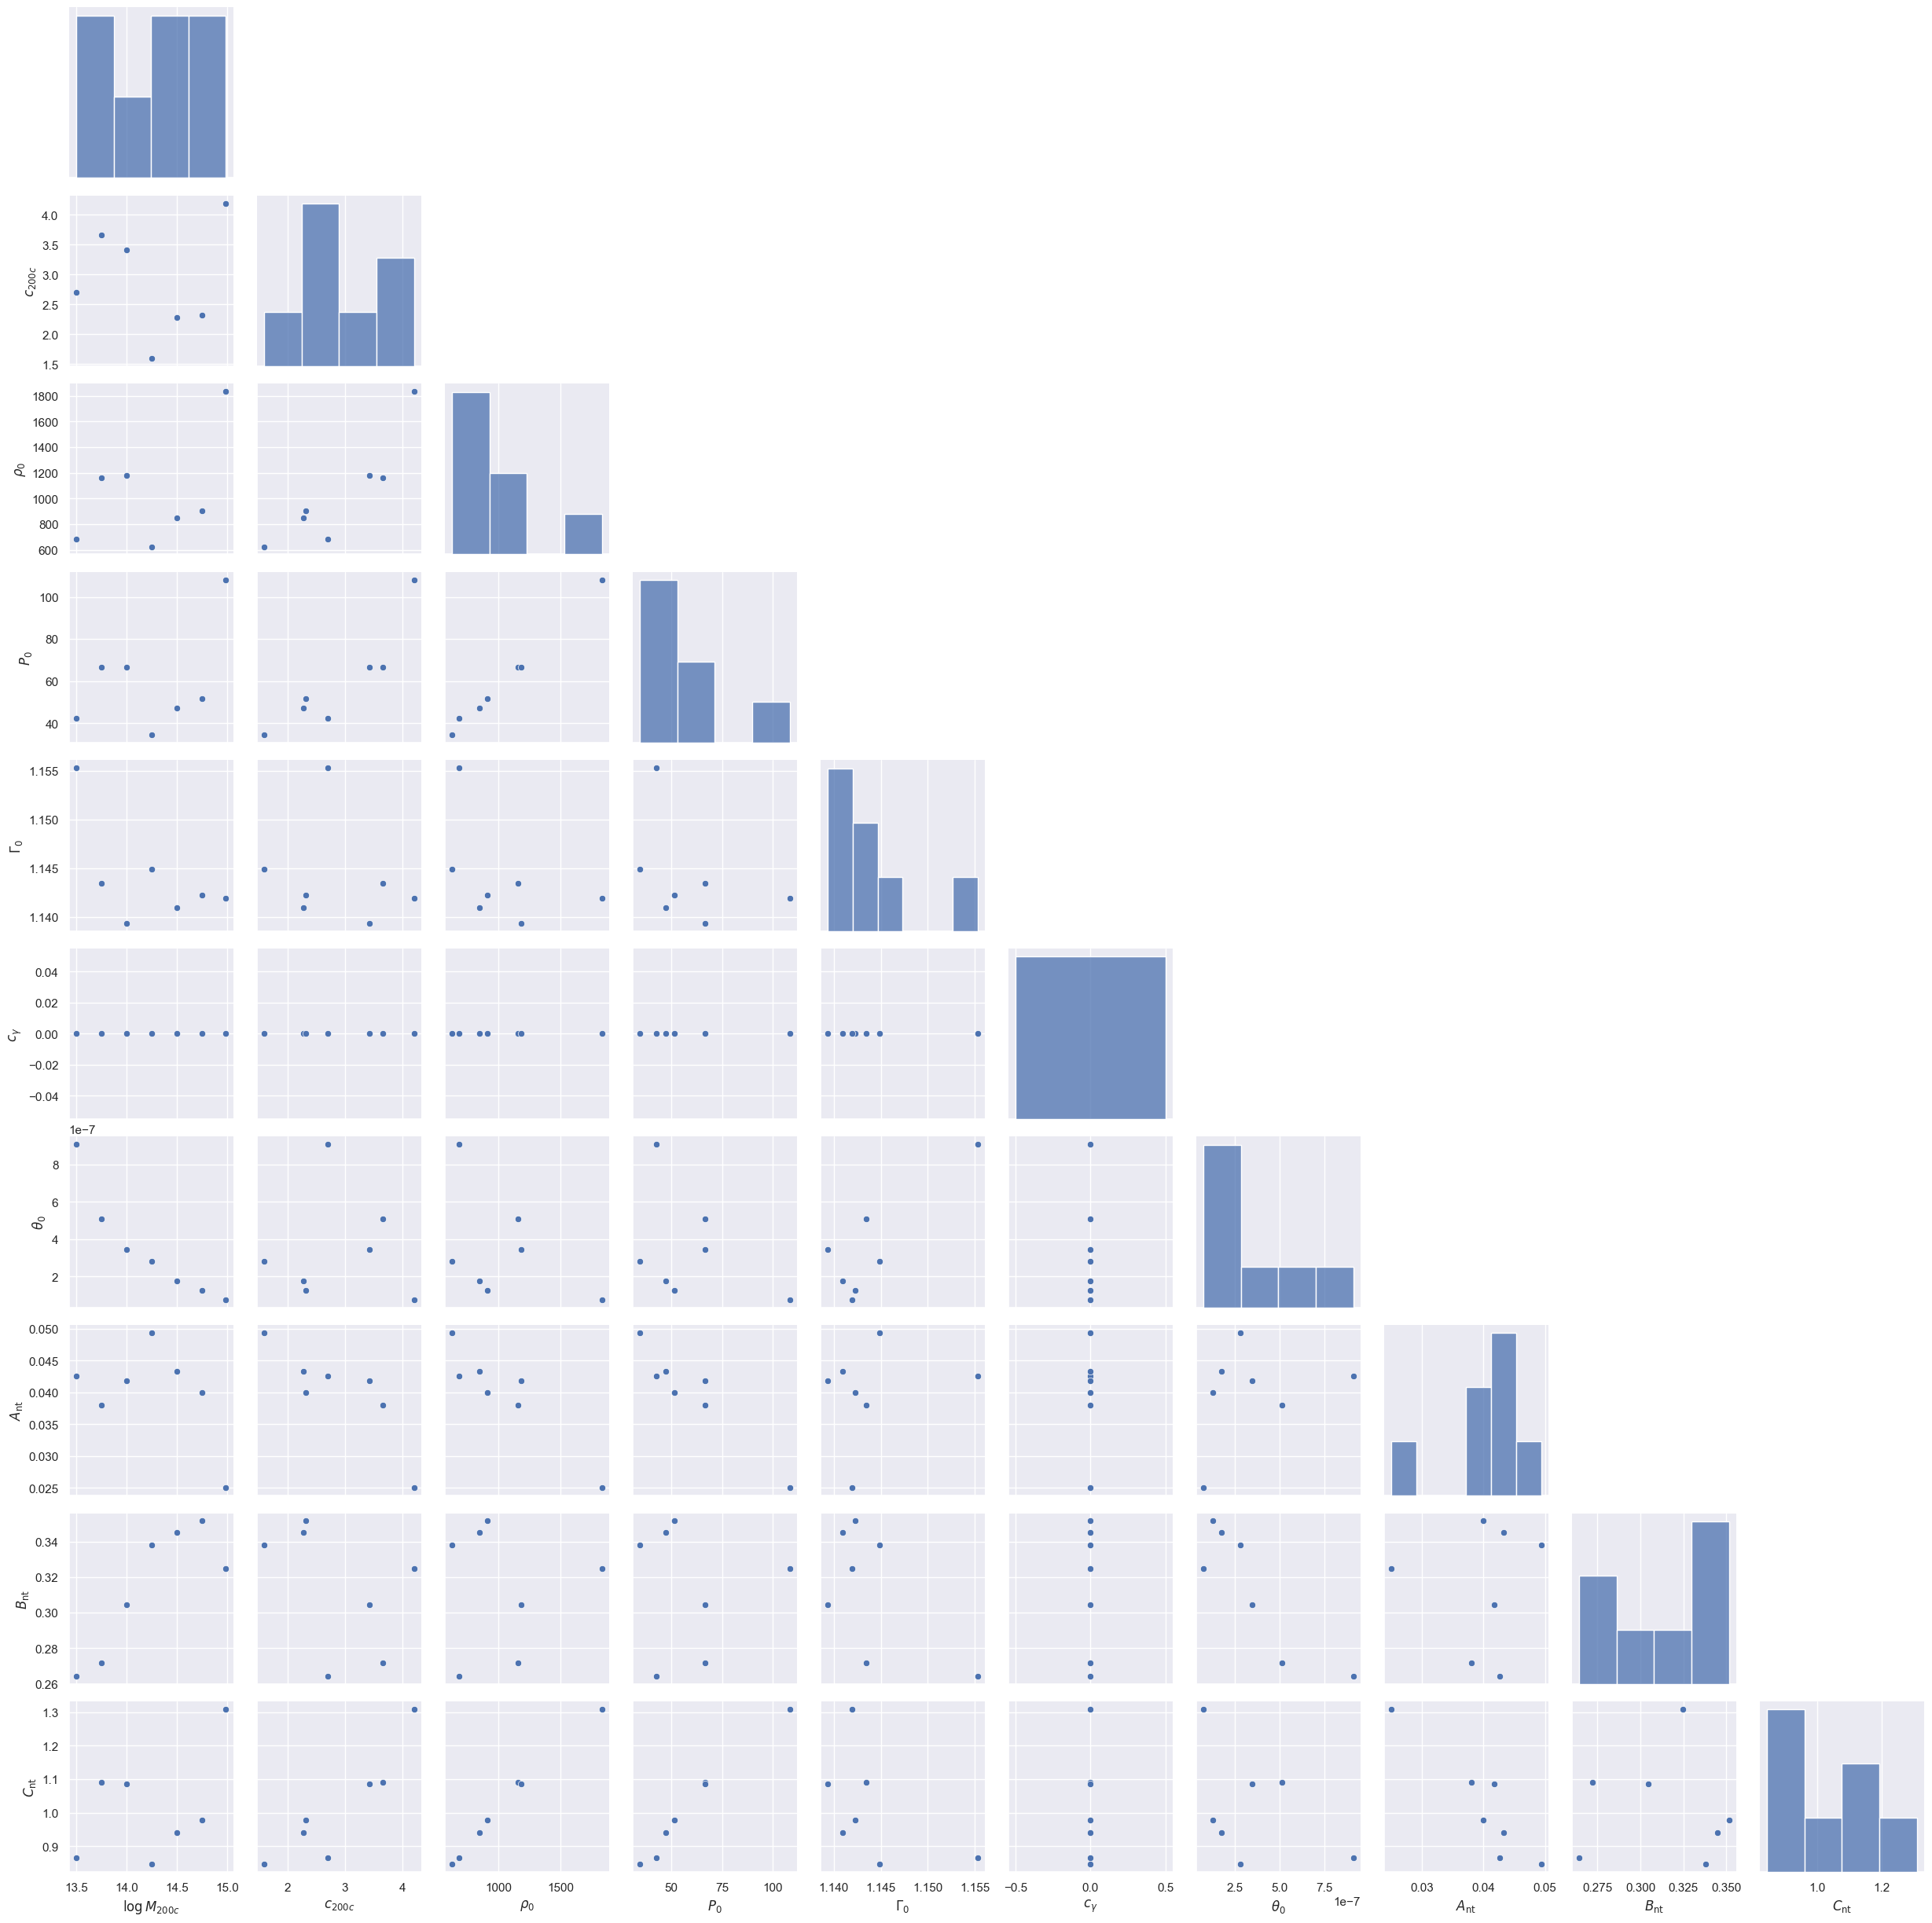

In [6]:
df = {"$\\log M_{200c}$": logM200c, "$c_{200c}$": c200c}
for i, name in enumerate(
    [
        "$\\rho_0$",
        "$P_0$",
        "$\\Gamma_0$",
        "$c_\\gamma$",
        "$\\theta_0$",
        "$A_{\\rm nt}$",
        "$B_{\\rm nt}$",
        "$C_{\\rm nt}$",
    ]
):
    df[name] = theta_gas[:, i]
df = Table(df).to_pandas()

pg = sns.PairGrid(df, corner=True, diag_sharey=False)
pg.map_lower(sns.scatterplot)
pg.map_diag(sns.histplot)

It can also be just-in-time compiled:

In [7]:
if benchmark:
    predict_jit = jax.jit(predictor.predict_model_parameters)
    print("Not jitted:", end=" ")
    %timeit _ = predictor.predict_model_parameters(theta_halo)
    print("jitted:", end=" ")
    _ = predict_jit(theta_halo)
    %timeit _ = predict_jit(theta_halo)

Not jitted: 8.42 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jitted: 9.99 µs ± 89 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Predicting gas thermodynamics

With a prediction for $\vartheta_{\rm gas}$, we can use `picasso.polytrop` and `picasso.nonthermal` to predict gas thermodynamics (see {doc}`demo_model`).
`PicassoPredictor` objects also offers a wrapper function that predicts all thermodynamic properties directly from an input vector $\vartheta_{\rm halo}$ and a potential distribution.
Assuming the halos above are NFW, we can predict their potential profiles:

In [8]:
r_R500c, phi = profs["r_R500"], profs["phi"]

Then, we can make predictions of gas thermodynamics for one halo:

In [9]:
rho_g, P_tot, P_th, f_nt = predictor.predict_gas_model(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)

Or for all halos at the same time (this function uses `jax.vmap` to vectorize the predictions):

In [10]:
rho_g, P_tot, P_th, f_nt = predictor.predict_gas_model(theta_halo, phi, r_R500c, r_R500c / 2)

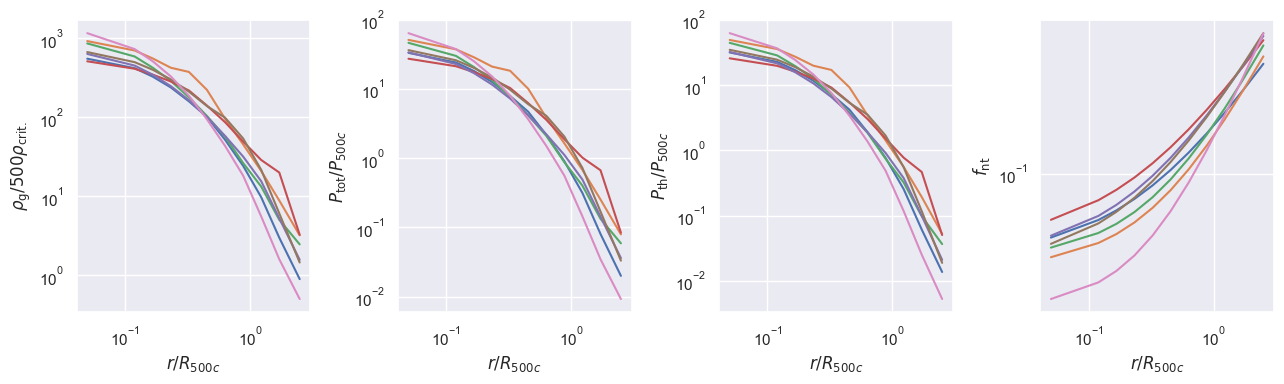

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for ax, q in zip(axs, [rho_g, P_tot, P_th, f_nt]):
    ax.loglog(r_R500c.T, q.T)
    ax.set_xlabel("$r / R_{500c}$")

axs[0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit.}$")
axs[1].set_ylabel("$P_{\\rm tot} / P_{500c}$")
axs[2].set_ylabel("$P_{\\rm th} / P_{500c}$")
axs[3].set_ylabel("$f_{\\rm nt}$")
fig.tight_layout()

Again, these functions can be just-in-time compiled:

In [12]:
if benchmark:
    predict_jit = jax.jit(predictor.predict_gas_model)

    print("1 halo, not jitted:", end=" ")
    %timeit _ = predictor.predict_gas_model(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)
    print("1 halo, jitted:", end=" ")
    _ = predict_jit(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)
    %timeit _ = predict_jit(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)

    print("4 halo, not jitted:", end=" ")
    %timeit _ = predictor.predict_gas_model(theta_halo, phi, r_R500c, r_R500c / 2)
    print("4 halo, jitted:", end=" ")
    _ = predict_jit(theta_halo, phi, r_R500c, r_R500c / 2)
    %timeit _ = predict_jit(theta_halo, phi, r_R500c, r_R500c / 2)

1 halo, not jitted: 8.71 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1 halo, jitted: 155 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4 halo, not jitted: 15.1 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4 halo, jitted: 28.7 µs ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


For an example of how these predictions can be included in a differentiable loss function and used to train a `picasso` model, see {doc}`../notebooks/train_model`.